In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import sklearn.feature_selection as fs
import skfda

#from lsuv_init import LSUVinit
from datetime import datetime

from tensorflow import keras
from tensorflow_addons.losses import PinballLoss
from sklearn.preprocessing import StandardScaler
#from numba import cuda

#cuda.select_device(0)
#cuda.close()

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus :
    try :
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e :
        print(e)

# https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output

# Attention, weight initializing

# Neural-ODE
os.chdir("./tfdiffeq-master")
import tfdiffeq as ODE
import tfdiffeq.models as ODEModels
os.chdir("../")

In [2]:
#os.chdir("./gru_ode_bayes-master")
#import gru_ode_bayes
#os.chdir("../")


In [3]:
lookback = 48 * 2
interval = 1

def GHI(data) :
    
    d = data["Day"] % 365
    longitude  = 37.532600
    Tutc = 9
    LSTM = 15 * Tutc
    B = (360 / 365) * (d - 81)
    EoT = 9.87 * np.sin(2 * B) - 7.53 * np.cos(B) - 1.5 * np.sin(B)
    TC = 4 * (127.024612 - LSTM) + EoT
    LST = data["Hour"] + (TC / 60)
    LST[np.array(range(1, LST.shape[0], 2))] += 0.7
    HRA = 15 * (LST- 12)

    theta = np.arcsin(np.sin(23.45) * np.sin(B))
    alpha = np.arcsin(np.sin(theta) * np.sin(longitude) + np.cos(theta) * np.cos(longitude) * np.cos(HRA))
    Zenith = 90 - alpha
    GHI = data["DHI"] + (data["DNI"] * Zenith)
    data.loc[:, "GHI"] = GHI
    
    return

def applyFeatureEngineering(data) :
    data.loc[:, "GHI"] = data["DHI"] + data["DNI"]
    
#    data.loc[:, "DNI"] = np.log(data["DNI"] + 1)
#    data.loc[:, "DHI"] = np.log(data["DHI"] + 1)
#    data.loc[:, "WS"] = np.log(data["WS"] + 1)
#    GHI(data)
#    data.loc[:, "RH"] /= 100
#    formula = np.log(data["RH"]) + (17.62 * data["T"]) / (243.12 + data["T"])
#    data.loc[:, "DP"] = (243.12 * formula) / (17.62 - formula)
#    data.loc[:, "Dew"] = data["T"] - data["DP"]
#    data.loc[:, "WT"] = data["T"] - (data["Dew"] / 3)
    data = data[["Day", "Hour", "Minute", "DHI", "DNI", "RH", "WS", "T", "GHI", "TARGET"]]
#    data = pd.concat([data, data.rolling(window = interval, min_periods = 1).mean().drop(["Day", "Hour", "Minute"], axis = "columns").add_suffix("_AVG")], axis = 1)    
    return data



In [4]:
train = pd.read_csv("./RawData/train/train.csv")

train = applyFeatureEngineering(train)

train.describe()


Day          Hour        Minute           DHI           DNI  \
count  52560.000000  52560.000000  52560.000000  52560.000000  52560.000000   
mean     547.000000     11.500000     15.000000     64.344121    234.792371   
std      316.102148      6.922252     15.000143    103.897125    349.684583   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      273.000000      5.750000      0.000000      0.000000      0.000000   
50%      547.000000     11.500000     15.000000      0.000000      0.000000   
75%      821.000000     17.250000     30.000000     87.000000    469.000000   
max     1094.000000     23.000000     30.000000    528.000000   1059.000000   

                 RH            WS             T           GHI        TARGET  
count  52560.000000  52560.000000  52560.000000  52560.000000  52560.000000  
mean      56.793102      2.456033      9.279928    299.136492     17.790630  
std       22.052875      1.426874     10.179741    392.456413     25.759955  
min        7.590000      0.000000    -19.000000      0.000000      0.000000  
25%       39.697500      1.400000      1.000000      0.000000      0.000000  
50%       57.600000      2.200000      9.000000      0.000000      0.000000  
75%       72.770000      3.200000     17.000000    655.000000     32.089890  
max      100.000000     12.000000     35.000000   1153.000000     99.913939

In [5]:
class DecimalScaler :
    def __init__(self) :
        self.dec = 0
        return
    
    def calculate(self, data) :
        return data / self.dec
    
    def fit(self, data) :
        self.dec = 10 ** np.array([len(i.split('.')[0]) for i in np.floor(data.max()).astype(str)])
        return
        
    def fit_transform(self, data) :
        self.fit(data)
        return self.calculate(data)
    
    def transform(self, data) :
        return self.calculate(data)
    
    def inverse_transform(self, data) :
        return data * self.dec

In [6]:
columnsIndex = np.array(range(train.columns.values.shape[0]))[np.isin(train.columns.values, ["TARGET", "RH", "WS", "T", "DHI", "DNI", "GHI"])]

trainFeature_2d = pd.DataFrame(train.iloc[:48 * 48 * 15, columnsIndex].reset_index(drop = True), columns = train.columns)
trainTarget_2d = train["TARGET"].iloc[:48 * 48 * 15]
trainTarget_2d = pd.DataFrame(trainTarget_2d.values.reshape(-1, 1), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(train.iloc[48 * 48 * 15:, columnsIndex].reset_index(drop = True), columns = train.columns)
validTarget_2d = train["TARGET"].iloc[48 * 48 * 15:]
validTarget_2d = pd.DataFrame(validTarget_2d.values.reshape(-1, 1), index = validFeature_2d.index)

featureScaler = StandardScaler()
targetScaler = StandardScaler()

trainFeature_2d = pd.DataFrame(featureScaler.fit_transform(trainFeature_2d), index = trainFeature_2d.index, columns = train.columns)
trainTarget_2d = pd.DataFrame(targetScaler.fit_transform(trainTarget_2d), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(featureScaler.transform(validFeature_2d), index = validFeature_2d.index, columns = train.columns)
validTarget_2d = pd.DataFrame(targetScaler.transform(validTarget_2d), index = validFeature_2d.index)

C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [8]:
output_dim = 1024
reg = 0

def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

In [9]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        #self.distribution = tfp.distributions.Sample(distribution = tfp.distributions.Gamma(concentration=2, rate = 2), sample_shape = 2)

        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

In [10]:
NVP_train = tf.convert_to_tensor(trainFeature_2d[["TARGET", "DNI"]], dtype = tf.float32)
NVP_valid = tf.convert_to_tensor(validFeature_2d[["TARGET", "DNI"]], dtype = tf.float32)

In [ ]:
model = RealNVP(num_coupling_layers=12)

model.compile(optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.0001))
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", verbose = 1, patience = 10, factor = np.log10(3), min_delta = 0.0005)

history = model.fit(
    NVP_train, batch_size=256, epochs=300, verbose=2, shuffle = False, validation_split = .2
)

Epoch 1/300


(-2.0, 3.0)

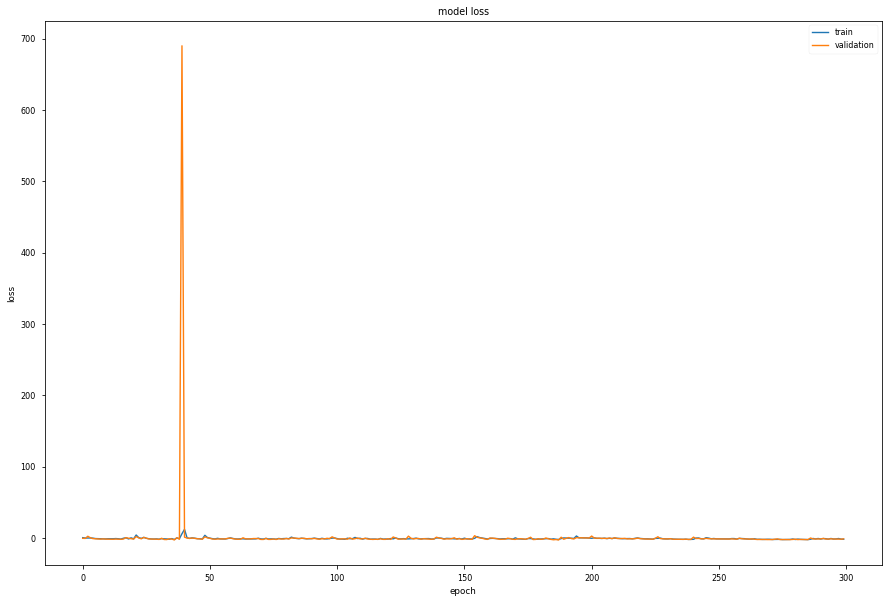

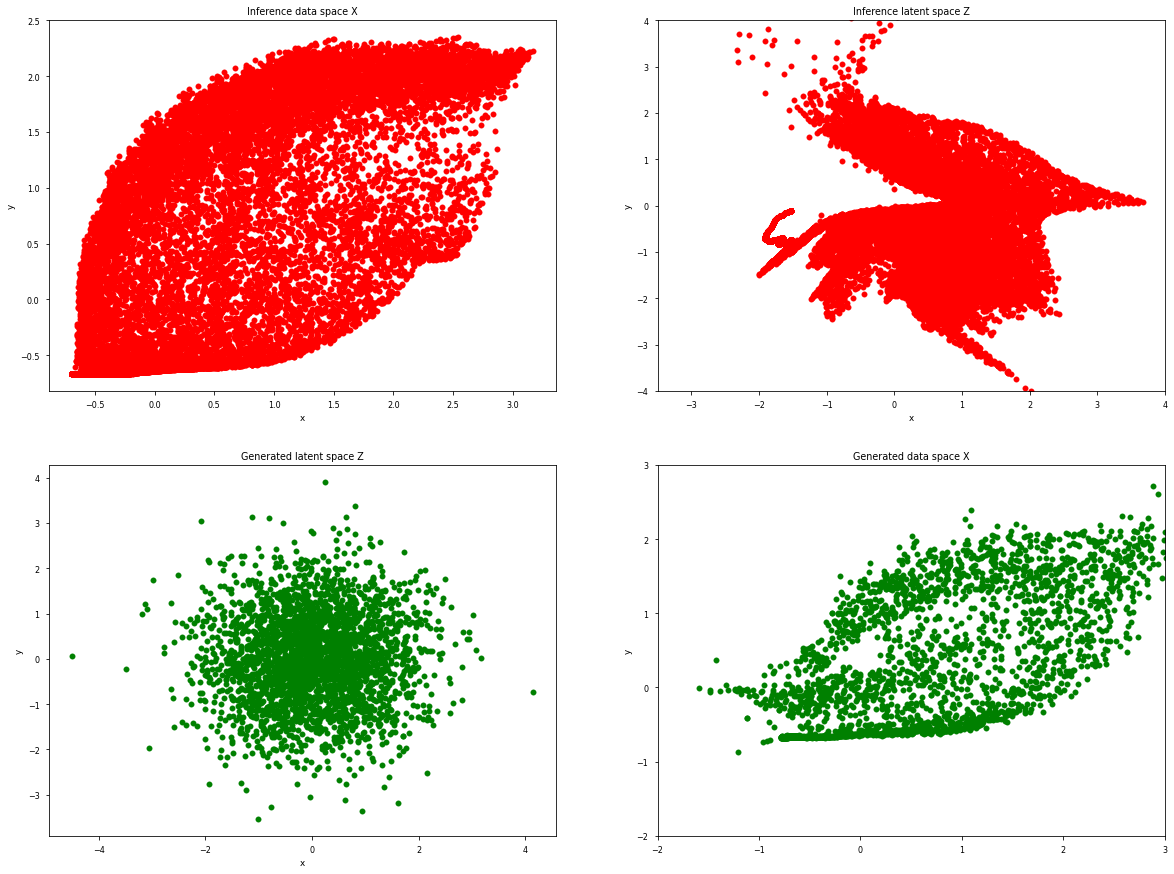

In [19]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(NVP_train)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(NVP_train[:, 0], NVP_train[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 3])
axes[1, 1].set_ylim([-2, 3])

In [7]:
trainFData = skfda.FDataGrid(trainFeature_2d, np.linspace(0, 1, num = 7))
validFData = skfda.FDataGrid(validFeature_2d, np.linspace(0, 1, num = 7))

In [8]:
trainFDataBasis = skfda.representation.basis.Monomial(domain_range=(0,1), n_basis = 2)
trainFDataBasis_fd = trainFData.to_basis(trainFDataBasis)

validFDataBasis = skfda.representation.basis.Monomial(domain_range=(0,1), n_basis = 2)
validFDataBasis_fd = validFData.to_basis(validFDataBasis)

FPCA = skfda.preprocessing.dim_reduction.projection.FPCA(2)
train_fpca = FPCA.fit_transform(trainFDataBasis_fd)
valid_fpca = FPCA.transform(validFDataBasis_fd)

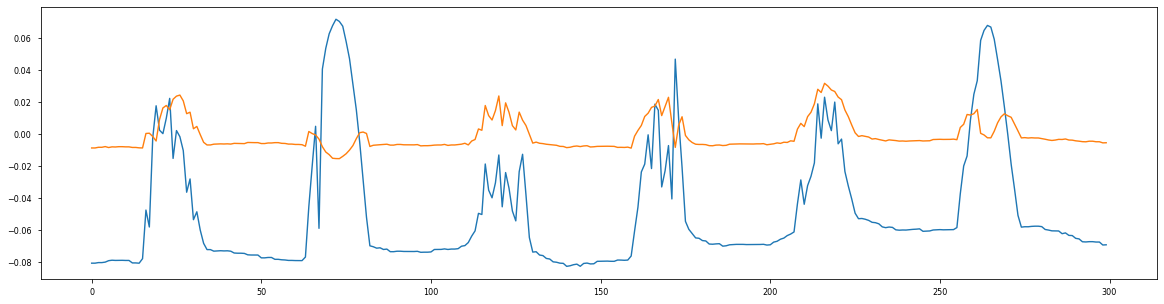

In [9]:
plt.figure(figsize = (20, 5))
plt.plot(train_fpca[0:300,:])

In [10]:
trainFeature_2d.loc[:, ["FPCA_1", "FPCA_2"]] = train_fpca
validFeature_2d.loc[:, ["FPCA_1", "FPCA_2"]] = valid_fpca

In [11]:
trainFeature_2d.columns

Index(['DHI', 'DNI', 'RH', 'WS', 'T', 'GHI', 'TARGET', 'FPCA_1', 'FPCA_2'], dtype='object')

In [12]:
fs.mutual_info_regression(trainFeature_2d, trainTarget_2d.values.reshape(-1), n_neighbors = 15)

array([1.31040272, 0.84659659, 0.34193198, 0.04882452, 0.23072533,
       1.47632222, 4.14755751, 1.39889202, 0.88474108])

In [13]:
fs.f_regression(trainFeature_2d, trainTarget_2d.values.reshape(-1))

(array([2.67447062e+04, 7.90689421e+04, 2.94795362e+04, 1.62689984e+03,
        1.60477979e+04, 1.91093717e+05, 1.94544245e+19, 1.15802994e+06,
        5.94785053e+01]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.26946776e-14]))

In [14]:
def makeTimeData(feature, target, timeStep, slideSize) :
    """
    timeStep  : How many "times" will LSTM look back? (Standard : 30 minutes)
                if timeStep value is 336, LSTM will predict target value with past 7 days
    slideSize : Period of standard in time series
    """
    
    newFeature = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, timeStep, feature.shape[1]))
    newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96, 1))
    #newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96))

    for i in range(newFeature.shape[0]) :
        newFeature[i] = feature.iloc[(i * slideSize) : (i * slideSize) + timeStep, :]
        newTarget[i] = target.iloc[(i * slideSize) + timeStep : (i * slideSize) + timeStep + 96]#.values.reshape(-1)

    newFeature = tf.convert_to_tensor(newFeature)
    newTarget = tf.convert_to_tensor(newTarget)
        
    return newFeature, newTarget

trainFeature, trainTarget = makeTimeData(trainFeature_2d, trainTarget_2d, lookback, interval)
validFeature, validTarget = makeTimeData(validFeature_2d, validTarget_2d, lookback, interval)

trainARFeature, trainARTarget = makeTimeData(pd.DataFrame(trainFeature_2d["TARGET"]), trainTarget_2d, lookback, interval)
validARFeature, validARTarget = makeTimeData(pd.DataFrame(validFeature_2d["TARGET"]), validTarget_2d, lookback, interval)

trainTarget_2d = trainTarget_2d.shift(-96).dropna().reset_index(drop = True)
validTarget_2d = validTarget_2d.shift(-96).dropna().reset_index(drop = True)

trainFeature_2d = trainFeature_2d.iloc[:trainFeature_2d.shape[0] - 96, :].reset_index(drop = True)
validFeature_2d = validFeature_2d.iloc[:validFeature_2d.shape[0] - 96, :].reset_index(drop = True)

In [177]:
def DARNN(tau, unit) :
    featureInput = keras.layers.Input(shape = (lookback, trainFeature.shape[2]))
    arInput = keras.layers.Input(shape = (lookback, 1))
    ######## Input Attention
    # Must use only feature, not target of previous time sequence!
    enc_out, enc_hidden, enc_cell = keras.layers.LSTM(unit, return_state = True, return_sequences = True, recurrent_initializer = "glorot_normal")(featureInput)
    enc_concat = keras.layers.Concatenate()([enc_hidden, enc_cell])
    
    term_1 = keras.layers.Dense(lookback, activation = None, use_bias = False, name = "term_1")(enc_concat)
    term_1_repeat = keras.layers.RepeatVector(trainFeature.shape[2])(term_1)
    term_1_T = keras.layers.Permute((2, 1))(term_1_repeat)
    term_2 = keras.layers.Dense(trainFeature.shape[2], activation = None, use_bias = False, name = "term_2")(featureInput)
    tanh = tf.tanh(term_1_T + term_2, name = "tanh")
    e = keras.layers.Dense(1, activation = None, use_bias = False, name = "e")(tanh)
    alpha = keras.layers.Activation("softmax")(e)
    
    newData = keras.layers.Multiply()([alpha, featureInput])
    
    ######## Decoder
    dec_out, dec_hidden, dec_cell = keras.layers.LSTM(unit, return_state = True, recurrent_initializer = "glorot_normal")(newData)
    dec_concat = keras.layers.Concatenate()([dec_hidden, dec_cell])
    
    dec_term_1 = keras.layers.Dense(lookback, activation = None, use_bias = False)(dec_concat)
    dec_term_1_repeat = keras.layers.RepeatVector(unit)(dec_term_1)
    dec_term_1_T = keras.layers.Permute((2, 1))(dec_term_1_repeat)
       
    dec_term_2 = keras.layers.Dense(unit, activation = None, use_bias = False)(enc_out)
    tanh = tf.tanh(dec_term_1_T + dec_term_2)
    
    li = keras.layers.Dense(1, activation = None, use_bias = False)(tanh)
    
    beta = keras.layers.Activation("softmax", name = "beta")(li)
    
    multiply = keras.layers.Multiply()([beta, enc_hidden])
    
    contextVector = tf.reduce_sum(multiply, axis = 2, keepdims = True)
    
    arConcat = keras.layers.Concatenate()([contextVector, arInput])
    
    newY = keras.layers.Dense(1, activation = None)(arConcat)
    
    dt, dt_hidden, dt_cell = keras.layers.LSTM(unit, return_state = True, return_sequences = True, recurrent_initializer = "glorot_normal")(newY)
    
    pred_concat = keras.layers.Concatenate()([dt, contextVector])
    
    pred_1 = keras.layers.Dense(1, activation = None)(pred_concat)
    OutputLayer = keras.layers.Dense(1, activation = None)(pred_1)
    
    model = keras.models.Model(inputs = [featureInput, arInput], outputs = OutputLayer)
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.005)
    model.compile(optimizer = optimizer, loss = PinballLoss(tau = tau), metrics = ["mae"])

    return model

model = DARNN(.5, 10)
model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 96, 8)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 96, 10), (No 760         input_13[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20)           0           lstm_8[0][1]                     
                                                                 lstm_8[0][2]                     
__________________________________________________________________________________________________
term_1 (Dense)                  (None, 96)           1920        concatenate[0][0]    

In [15]:
batch_size = 256
es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, restore_best_weights = True)
#lr = keras.callbacks.LearningRateScheduler(schedule = keras.experimental.CosineDecay(initial_learning_rate = 0.005, decay_steps = 30, alpha = 1e-8))
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.log10(3), patience = 10, verbose = 1, min_delta = 0.0005)


modelList = {}
for i in range(5, 6) :
    modelList[str(np.round(i * .1, decimals = 1))] = DARNN(np.round(i * .1, decimals = 1), 24)
    print("Tau : " + str(np.round(i * .1, decimals = 1)))
    modelList[str(np.round(i * .1, decimals = 1))].fit([trainFeature, trainARFeature], trainTarget, epochs = 500, shuffle = False,
                                                       validation_data = ([validFeature, validARFeature], validTarget), batch_size = batch_size, callbacks = [lr, es])

NameError: name 'DARNN' is not defined

In [44]:
batch_size = 32

def createModel(tau) :
    InputLayer = keras.layers.Input(shape = (trainFeature.shape[1], trainFeature.shape[2]), batch_size = 32)
    
    LSTM = keras.layers.LSTM(trainFeature.shape[2], recurrent_initializer = "glorot_normal", return_sequences = True, stateful = True)(InputLayer)
    Multiply = keras.layers.Multiply()([InputLayer, LSTM])
    
    LSTM = keras.layers.LSTM(trainFeature.shape[2], recurrent_initializer = "glorot_normal", return_sequences = True, stateful = True)(Multiply)
    Multiply = keras.layers.Multiply()([Multiply, LSTM])
    
    LSTM_Weight = keras.layers.TimeDistributed(keras.layers.Dense(trainFeature.shape[2], activation = None, use_bias = False))(Multiply)
    
    Input_Weight = keras.layers.TimeDistributed(keras.layers.Dense(trainFeature.shape[2], activation = None, use_bias = False))(InputLayer)
    
    Add = keras.layers.Add()([LSTM_Weight, Input_Weight])
    
    OutputLayer = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = None))(Add)
    model = keras.models.Model(inputs = InputLayer, outputs = OutputLayer)
    
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.0005)
    model.compile(optimizer = optimizer, loss = PinballLoss(tau = tau), metrics = ["mae"])
    return model


In [45]:
model = createModel(.5)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(32, 96, 7)]        0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (32, 96, 7)          420         input_5[0][0]                    
__________________________________________________________________________________________________
multiply_9 (Multiply)           (32, 96, 7)          0           input_5[0][0]                    
                                                                 lstm_7[0][0]                     
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (32, 96, 7)          420         multiply_9[0][0]      

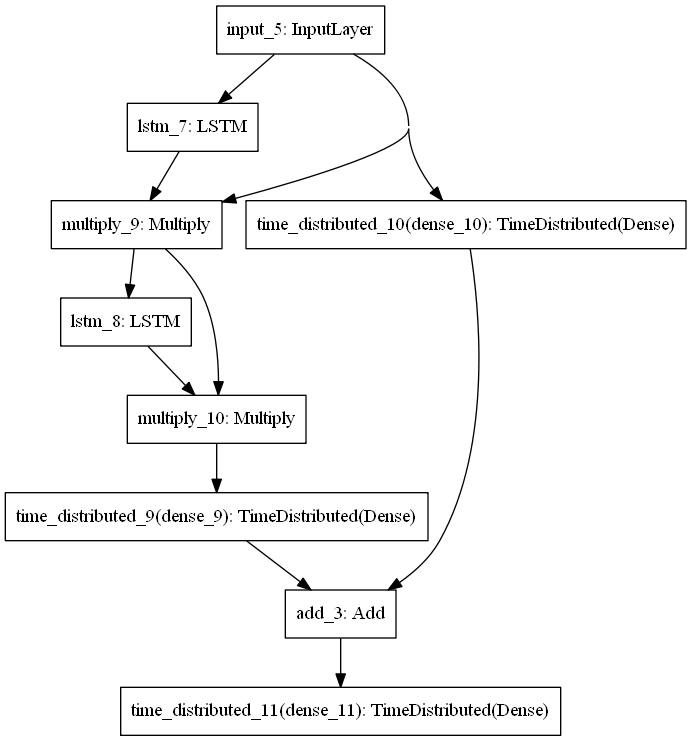

In [46]:
keras.utils.plot_model(model)

In [ ]:
for i in range(0, trainFeature.shape[0] - 64, 32) :
    print("Epochs : ", i // 32)
    model.fit(trainFeature[i : i + 32], trainTarget[i: i + 32], epochs = 20, shuffle = False, validation_data = (trainFeature[i + 32 : i + 64], trainTarget[i + 32 : i + 64]))

Epochs :  0
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0311 - mae: 0.0621 - val_loss: 0.0354 - val_mae: 0.0707
Epoch 2/20
1/1 [==============================] - 0s 24ms/step - loss: 0.0310 - mae: 0.0621 - val_loss: 0.0353 - val_mae: 0.0707
Epoch 3/20
1/1 [==============================] - 0s 23ms/step - loss: 0.0310 - mae: 0.0620 - val_loss: 0.0353 - val_mae: 0.0706
Epoch 4/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0310 - mae: 0.0619 - val_loss: 0.0353 - val_mae: 0.0706
Epoch 5/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0309 - mae: 0.0618 - val_loss: 0.0353 - val_mae: 0.0706
Epoch 6/20
1/1 [==============================] - 0s 21ms/step - loss: 0.0309 - mae: 0.0618 - val_loss: 0.0353 - val_mae: 0.0705
Epoch 7/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0309 - mae: 0.0618 - val_loss: 0.0353 - val_mae: 0.0705
Epoch 8/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0309 - mae: 0.

1074/1074 [==============================] - 6s 6ms/step - loss: 0.0324 - mae: 0.0649


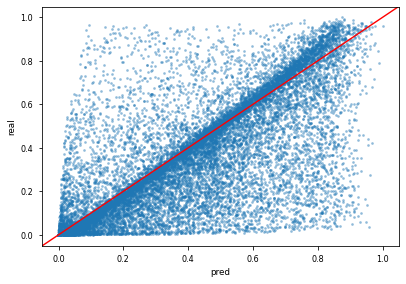

In [49]:
model.evaluate(trainFeature, trainTarget)
result = model.predict(trainFeature)
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = trainTarget[np.arange(trainTarget.shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

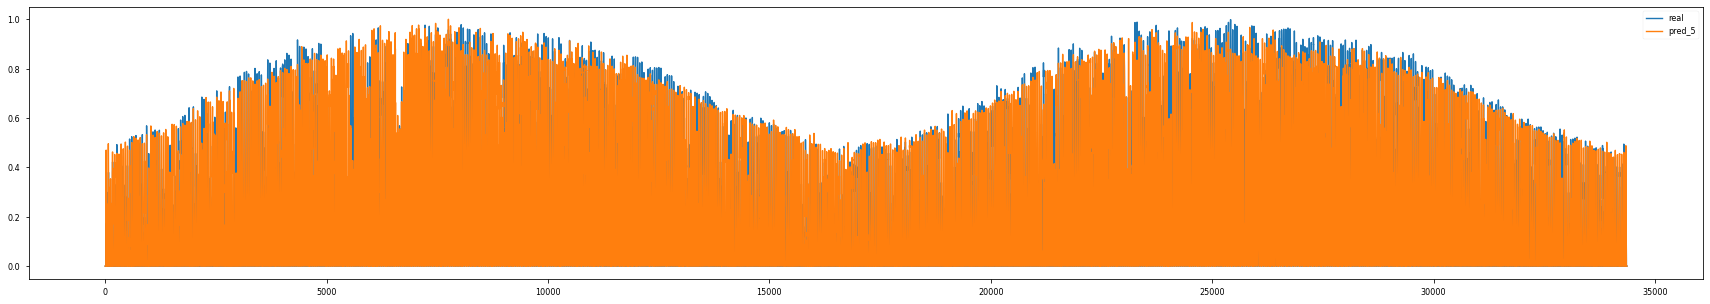

In [51]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")t
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8")
#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

556/556 [==============================] - 3s 6ms/step - loss: 0.0320 - mae: 0.0640


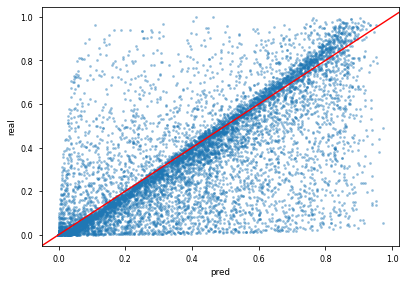

In [52]:
model.evaluate(validFeature[:-16], validTarget[:-16])

result = model.predict(validFeature[:-16])
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = validTarget[:-16][np.arange(validTarget[:-16].shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

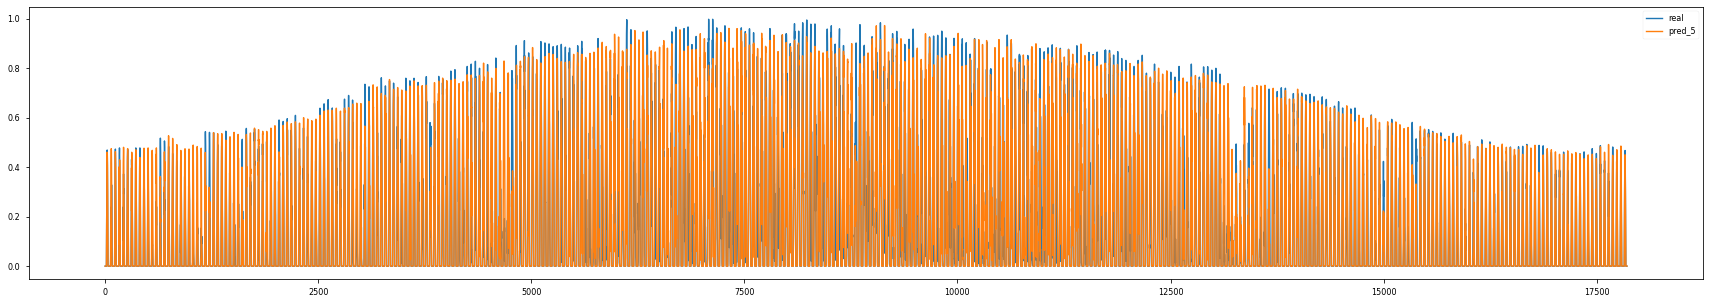

In [53]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8")
#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

In [ ]:
tfp.distributions.TransformedDistribution()

In [ ]:
es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, restore_best_weights = True)
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.log10(3), patience = 10, verbose = 1, min_delta = 0.0005)

modelList = {}
for i in range(5, 6) :
    modelList[str(np.round(i * .1, decimals = 1))] = createModel(np.round(i * .1, decimals = 1))
    print("Tau : " + str(np.round(i * .1, decimals = 1)))
    modelList[str(np.round(i * .1, decimals = 1))].fit(trainFeature, trainTarget, epochs = 200, shuffle = False,
                                                       validation_data = (validFeature[:-16], validTarget[:-16]), batch_size = 32, callbacks = [lr, es])

Tau : 0.5
Epoch 1/200
1074/1074 [==============================] - 37s 35ms/step - loss: 0.1166 - mae: 0.2331 - val_loss: 0.0640 - val_mae: 0.1281
Epoch 2/200
1074/1074 [==============================] - 35s 33ms/step - loss: 0.0553 - mae: 0.1107 - val_loss: 0.0537 - val_mae: 0.1073
Epoch 3/200
1074/1074 [==============================] - 35s 33ms/step - loss: 0.0499 - mae: 0.0998 - val_loss: 0.0513 - val_mae: 0.1026
Epoch 4/200
1074/1074 [==============================] - 35s 33ms/step - loss: 0.0451 - mae: 0.0901 - val_loss: 0.0438 - val_mae: 0.0877
Epoch 5/200
1074/1074 [==============================] - 35s 33ms/step - loss: 0.0381 - mae: 0.0762 - val_loss: 0.0376 - val_mae: 0.0752
Epoch 6/200
1074/1074 [==============================] - 38s 35ms/step - loss: 0.0351 - mae: 0.0703 - val_loss: 0.0355 - val_mae: 0.0711
Epoch 7/200
1074/1074 [==============================] - 37s 34ms/step - loss: 0.0343 - mae: 0.0685 - val_loss: 0.0348 - val_mae: 0.0695
Epoch 8/200
1074/1074 [========

In [15]:
def ODEModel(tau) :
    model = ODEModels.ODENet(hidden_dim=128, output_dim=1, time_dependent=True)

    optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.005)
    model.compile(optimizer = optimizer, loss = PinballLoss(tau = tau), metrics = ["mae"])
    return model
#model = ODEModel(0.5)
#model.fit(trainFeature_2d, trainTarget_2d, epochs = 200, shuffle = False,
#          validation_data = (validFeature_2d, validTarget_2d), batch_size = batch_size, callbacks = [lr, es])
#model.summary()

In [16]:
batch_size = 256

es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, restore_best_weights = True)
#lr = keras.callbacks.LearningRateScheduler(schedule = keras.experimental.CosineDecay(initial_learning_rate = 0.005, decay_steps = 30, alpha = 1e-8))
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.log10(3), patience = 10, verbose = 1, min_delta = 0.0005)

modelList = {}
for i in range(5, 6) :
    modelList[str(np.round(i * .1, decimals = 1))] = ODEModel(np.round(i * .1, decimals = 1))
    print("Tau : " + str(np.round(i * .1, decimals = 1)))
    modelList[str(np.round(i * .1, decimals = 1))].fit(trainFeature_2d, trainTarget_2d, epochs = 200, shuffle = False,
                                                       validation_data = (validFeature_2d, validTarget_2d), batch_size = batch_size, callbacks = [lr, es])

Tau : 0.5
Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

135/135 [==============================] - 26s 191ms/step - loss: 0.0361 - mae: 0.0722 - val_loss: 0.0337 - val_mae: 0.0674
Epoch 2/200
135/135 [==============================] - 25s 184ms/step - loss: 0.0341 - mae: 0.0682 - val_loss: 0.0325 - val_mae: 0.0651
Epoch 3/200
135/135 [==============================] - 25s 184ms/step - loss: 0.0335 - mae: 0.0670 - val_loss: 0.0331 - val_mae: 0.0662
Epoch 4/200
135/135 [==============================] - 24s 178ms/step - loss: 0.0339 - mae

KeyboardInterrupt: 

In [12]:
os.chdir("./Models/RNN/")
for i in modelList.keys() : 
    modelList[i].save("RNN_TAU_" + str(i))
os.chdir("../../")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: RNN_TAU_0.1\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.2\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.3\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.4\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.5\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.6\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.7\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.8\assets
INFO:tensorflow:Assets written to: RNN_TAU_0.9\assets


In [ ]:
# Data : 0-6일 모두 사용, time step은 하루 (48 rows)

es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0005, patience = 30, restore_best_weights = True)
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = 1)

trainingMode = True

modelList = {}
os.chdir("./Models/LSTM/")
for i in range(1, 10) :
    try :
        if trainingMode :
            raise OSError
        modelList[str(np.round(i * .1, decimals = 1))] = keras.models.load_model("LSTM_TAU_" + str(np.round(i * .1, decimals = 1)), compile = False)
        modelList[str(np.round(i * .1, decimals = 1))].compile(optimizer = "adam", loss = PinballLoss(tau = np.round(i * .1, decimals = 1)))
        print("Success to load LSTM model : LSTM_TAU_" + str(np.round(i * .1, decimals = 1)))
        print("Loss on Tau = " + str(np.round(i * .1, decimals = 1)))
        modelList[str(np.round(i * .1, decimals = 1))].evaluate(trainFeature, trainTarget)
        print("**********************************************")
    except OSError :  
        modelList[str(np.round(i * .1, decimals = 1))] = createModel(np.round(i * .1, decimals = 1))
        print("Tau : " + str(np.round(i * .1, decimals = 1)))
        modelList[str(np.round(i * .1, decimals = 1))].fit(trainFeature, trainTarget, epochs = 150, shuffle = False, validation_data = (validFeature, validTarget), callbacks = [lr, es])
        if not trainingMode :
            modelList[str(np.round(i * .1, decimals = 1))].save("LSTM_TAU_" + str(np.round(i * .1, decimals = 1)))
            print("Success to save LSTM model : LSTM_TAU_" + str(np.round(i * .1, decimals = 1)))
os.chdir("../../")


In [17]:
result = modelList["0.5"].predict(trainFeature_2d)
plotResult_5 = result.reshape(-1)
plotReal = trainTarget_2d.values.reshape(-1)
plotResult_5.shape

ValueError: in user code:

    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Shadow\anaconda3\envs\SunLight\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv1d_3 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [32, 7]


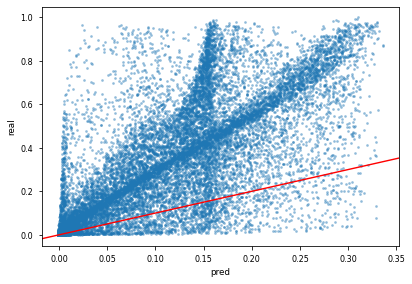

In [11]:
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

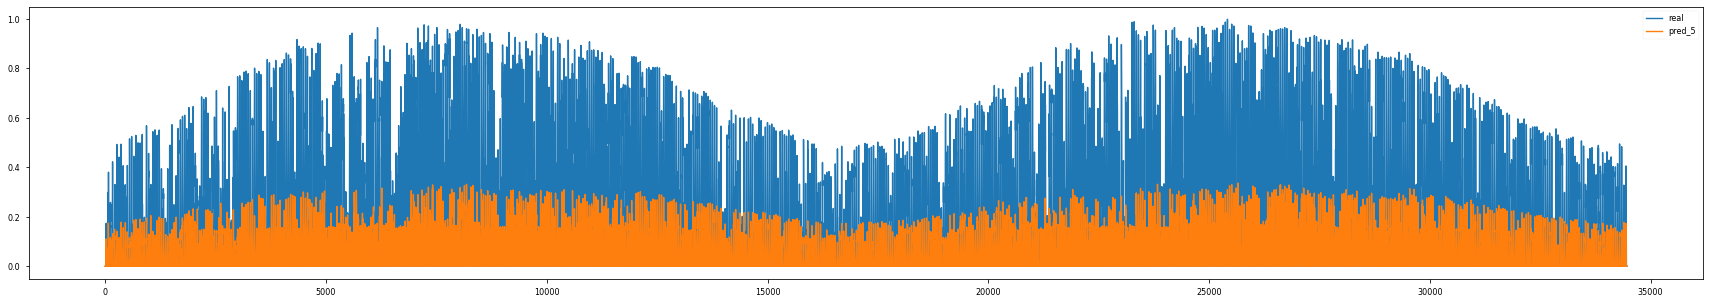

In [12]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8"

#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

In [15]:
result = modelList["0.1"].predict(validFeature_2d)
plotResult_5 = result.reshape(-1)
plotReal = validTarget_2d.values.reshape(-1)
plotResult_5.shape

(17904,)

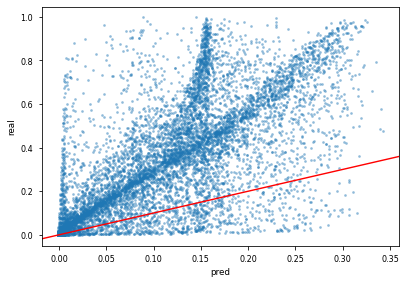

In [16]:
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

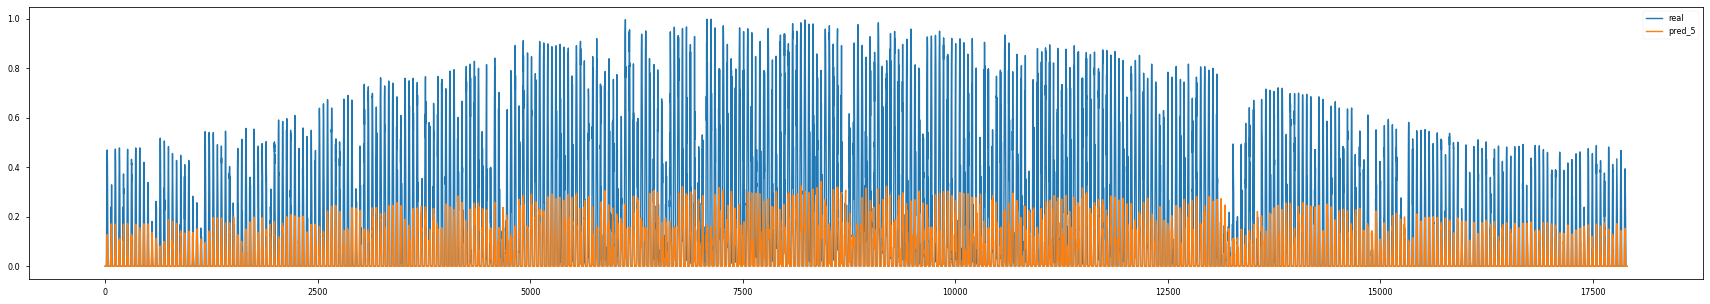

In [17]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8"

#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

In [1]:
result = modelList["0.5"].predict(trainFeature)
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = trainTarget[np.arange(trainTarget.shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)

NameError: name 'modelList' is not defined

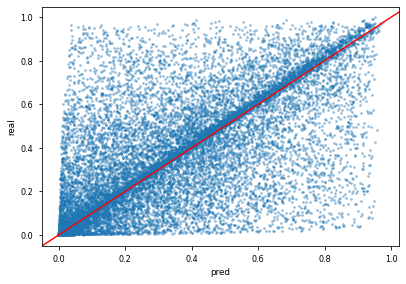

In [85]:
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

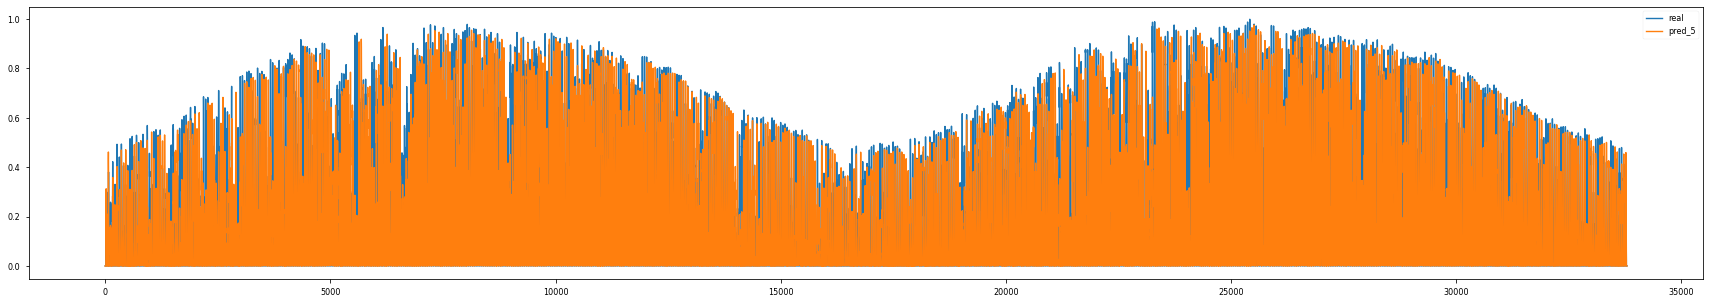

In [86]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8"

#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

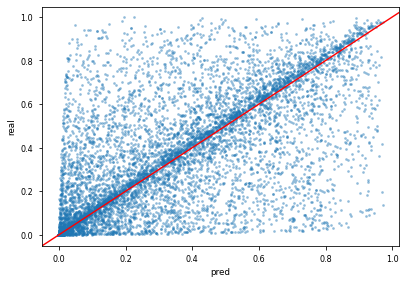

In [88]:
result = modelList["0.5"].predict(validFeature[:-25])
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = validTarget[:-25][np.arange(validTarget[:-25].shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

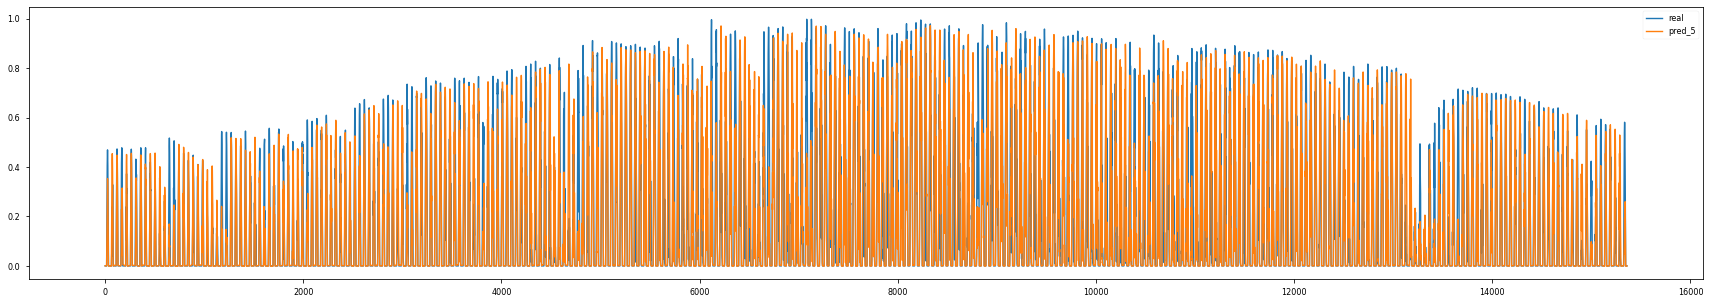

In [90]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8")
#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

In [92]:
getLayerOutput = keras.backend.function([modelList["0.5"].layers[0].input], 
                                        [modelList["0.5"].layers[1].output])

hidden_1 = np.array(getLayerOutput([trainFeature])).reshape(358, -1)

plt.figure(figsize = (20, 5))
plt.plot(hidden_1[:, :])


InvalidArgumentError: Invalid input_h shape: [1,32,7] [1,352,7] [Op:CudnnRNN]

In [67]:
submission = pd.read_csv("./RawData/sample_submission.csv")
submission.index = submission["id"]
submission.drop("id", axis = "columns", inplace = True)
originalIndex = submission.index
submission.index = [i.split("_")[0] for i in submission.index.values]
submission

q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  q_0.8  q_0.9
0.csv     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
0.csv     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
0.csv     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
0.csv     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
0.csv     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
...       ...    ...    ...    ...    ...    ...    ...    ...    ...
80.csv    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
80.csv    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
80.csv    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
80.csv    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
80.csv    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0

[7776 rows x 9 columns]

In [82]:
filelist = pd.DataFrame(glob.glob("./RawData/test/*.csv"), columns = ["filename"])
filelist.loc[:, "fileorder"] = [int(j.split(".")[0]) for j in [i.split("\\")[-1] for i in glob.glob("./RawData/test/*.csv")]]
filelist = filelist.sort_values("fileorder").reset_index(drop = True).drop("fileorder", axis = "columns")

testData = pd.read_csv(filelist.iloc[0].values[0])
testData = applyFeatureEngineering(testData)
testData = featureScaler.transform(testData.iloc[testData.shape[0] - lookback : , columnsIndex])
testExoFeature = testData.drop("TARGET", axis = "columns")
testExoFeature = testExoFeature.values.reshape(1, testExoFeature.shape[0], testExoFeature.shape[1])
testFeature = pd.DataFrame(testData["TARGET"])
testFeature = testFeature.values.reshape(1, testFeature.shape[0], testFeature.shape[1])

In [77]:
testData.values.reshape(1, testData.shape[0], testData.shape[1])

array([[[ 0.  ,  0.  ,  0.  , ..., 34.42,  0.  ,  0.  ],
        [ 0.  ,  0.  , 30.  , ..., 34.17,  0.1 ,  0.  ],
        [ 0.  ,  1.  ,  0.  , ..., 34.23,  0.2 ,  0.  ],
        ...,
        [ 6.  , 22.  , 30.  , ..., 53.89, -8.3 ,  0.  ],
        [ 6.  , 23.  ,  0.  , ..., 51.96, -8.4 ,  0.  ],
        [ 6.  , 23.  , 30.  , ..., 51.96, -8.4 ,  0.  ]]])

In [83]:
filelist = pd.DataFrame(glob.glob("./RawData/test/*.csv"), columns = ["filename"])
filelist.loc[:, "fileorder"] = [int(j.split(".")[0]) for j in [i.split("\\")[-1] for i in glob.glob("./RawData/test/*.csv")]]
filelist = filelist.sort_values("fileorder").reset_index(drop = True).drop("fileorder", axis = "columns")

for fileName in filelist["filename"] :
    testData = pd.read_csv(fileName)
    
    testData = applyFeatureEngineering(testData)
    
    testData = featureScaler.transform(testData.iloc[testData.shape[0] - lookback : , columnsIndex])
#    testData = testData.values.reshape(1, testData.shape[0], testData.shape[1])
    testExoFeature = testData.drop("TARGET", axis = "columns")
    testExoFeature = testExoFeature.values.reshape(1, testExoFeature.shape[0], testExoFeature.shape[1])
    testFeature = pd.DataFrame(testData["TARGET"])
    testFeature = testFeature.values.reshape(1, testFeature.shape[0], testFeature.shape[1])
    
    for tau in modelList.keys() :
        submission.loc[fileName.split("\\")[-1], "q_" + str(tau)] = targetScaler.inverse_transform(modelList[tau].predict([testExoFeature, testFeature]).reshape(-1, 1)).reshape(-1)

submission.index = originalIndex
submission

q_0.1     q_0.2     q_0.3     q_0.4     q_0.5  \
id                                                                     
0.csv_Day7_0h00m   -0.038034 -0.025916 -0.144689 -0.254253 -1.009048   
0.csv_Day7_0h30m   -0.068826 -0.034746 -0.053806 -0.233840  0.108845   
0.csv_Day7_1h00m   -0.095265 -0.097324  0.004064 -0.100752  0.451727   
0.csv_Day7_1h30m   -0.112712 -0.174680  0.042350 -0.016167  0.457312   
0.csv_Day7_2h00m   -0.120954 -0.247414  0.068257 -0.006533  0.351919   
...                      ...       ...       ...       ...       ...   
80.csv_Day8_21h30m -0.121738  0.065813 -0.010143  0.099988  0.044294   
80.csv_Day8_22h00m -0.090127  0.069245  0.018602  0.192996  0.049045   
80.csv_Day8_22h30m -0.073386  0.071762  0.020461  0.264688  0.057877   
80.csv_Day8_23h00m -0.069276  0.068038  0.004340  0.307344  0.073079   
80.csv_Day8_23h30m -0.073860  0.056177 -0.019771  0.321888  0.097589   

                       q_0.6     q_0.7      q_0.8     q_0.9  
id                                                           
0.csv_Day7_0h00m    0.785289  1.430403  11.631814  0.512695  
0.csv_Day7_0h30m    0.410044  0.984691   8.761440 -0.153274  
0.csv_Day7_1h00m    0.039432  0.525164   6.217830 -0.227376  
0.csv_Day7_1h30m   -0.256953  0.107802   4.055606 -0.196942  
0.csv_Day7_2h00m   -0.451888 -0.244565   2.295093 -0.460798  
...                      ...       ...        ...       ...  
80.csv_Day8_21h30m -0.396799 -0.129914  -0.041218  1.169198  
80.csv_Day8_22h00m -0.299743 -0.053820   0.014868  1.145832  
80.csv_Day8_22h30m -0.172868  0.010275   0.074153  1.145679  
80.csv_Day8_23h00m -0.046867  0.024140   0.084620  1.151285  
80.csv_Day8_23h30m  0.066165 -0.021133   0.027112  1.153271  

[7776 rows x 9 columns]

In [84]:
submission.to_csv("./Submission/" + str(datetime.now())[:-10].replace(" ", "_").replace(":", "") + ".csv")